In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Titanic Survival Prediction
## Objective: “what sorts of people were more likely to survive?” 
### Data Science general process
* Data Preprocessing - family size, passenger names (drop or extract titles?)
* Feature engineering - which features would have more weights? which one is more meaningful?
* Train a model - supervised model; which one?
* Evaluation and further

## **1. Data exploration and cleaning**
- null values/missing data -> drop/mean or median/machine learning
- correlation between features
- feature engineering -> which features to use/combine/drop/etc?
- non-numerical values to numerical values -> label encoding/one hot encoding/find and replace/etc

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [3]:
# read the training files
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_gender_data = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

# read the test file
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
# take a look at the train dataset..
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# have a look at the datasets
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
# not sure if we need this
train_gender_data.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


Now that the datasets are loaded (for training), let's check if there are any null values.

In [8]:
print(train_data.columns)
print(train_data.isnull().sum())

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [9]:
print(train_gender_data.columns)
print(train_gender_data.isnull().sum()) 
### calculate the ratio of null values over total number of rows to determine whether to drop the null values or not.

Index(['PassengerId', 'Survived'], dtype='object')
PassengerId    0
Survived       0
dtype: int64


As there is no null values in the gender data, we can just look at the train data and treat the null values. For Cabin and Embarked columns, let's replace the null values with Unknown. For Age column, we can visualize the data to see what filling method to use and to apply binning on the data.

In [10]:
# filling the null values in Cabin column
train_data['Cabin'] = train_data['Cabin'].fillna('Unknown')
train_data['Embarked'] = train_data['Embarked'].fillna('Unknown')

In [11]:
# apply the same for test data
test_data['Cabin'] = test_data['Cabin'].fillna('Unknown')
test_data['Embarked'] = test_data['Embarked'].fillna('Unknown')

Next, let's dive into filling null values in Age column. For this, we want to consider different features such as Sex and PClass to calculate mean age.

In [12]:
# tip from the forum - consider Pclass and sex while filling the Age column's null values with mean

# get the mean values via groupby
#mean_values = train_data.groupby(['Pclass', 'Sex'])['Age'].mean().round()
# how to fill the nan values with above mean?
#np.where(train_data['Pclass'] == 1 & train_data['Sex'] == 'female', train_data, train_data['Age'].fillna(mean_values[1][0]))

# from stackoverflow - fill nan values with mean from groupby: lambda or without lambda
# below will convert the data type to object
#train_data['Age'] = train_data.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.mean))

# below is without lambda - does not convert the data type.
train_data['Age'] = train_data['Age'].fillna(train_data.groupby(['Pclass', 'Sex'])['Age'].transform('mean'))

# train_data['Age'].dtype
#train_data['Age'].isnull().sum()

In [13]:
test_data['Age'] = test_data['Age'].fillna(test_data.groupby(['Pclass', 'Sex'])['Age'].transform('mean'))

Afterwards, let's visualize the non-null Age column.

count    891.000000
mean      29.318643
std       13.281103
min        0.420000
25%       21.750000
50%       26.507589
75%       36.000000
max       80.000000
Name: Age, dtype: float64


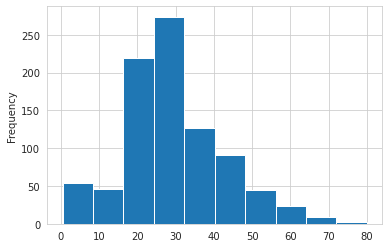

In [14]:
seaborn.set_style('whitegrid')
train_data['Age'].plot(kind='hist')
print(train_data['Age'].describe())

In [15]:
# binning for Age - how should we define the number of bins?
# qcut or cut?
qcut_sample = pd.qcut(train_data['Age'], q=3)
qcut_sample.value_counts()

(0.419, 24.0]    319
(32.5, 80.0]     296
(24.0, 32.5]     276
Name: Age, dtype: int64

Looks like the number of data points within each bin are more or less similar. What if we increase the number of bins?

In [16]:
qcut_sample = pd.qcut(train_data['Age'], q=5)
qcut_sample.value_counts()

(26.0, 30.0]     186
(20.0, 26.0]     182
(0.419, 20.0]    179
(30.0, 40.0]     173
(40.0, 80.0]     171
Name: Age, dtype: int64

Having 5 bins seems like more sophisticated than having 3 bins. We'll bin the Age column with 5 quantiles, along with the labels.

In [17]:
qcut_labels = ['Young', 'Early Twenties', 'Late Twenties', 'Thirties', 'Mid-Old']
train_data['Age'] = pd.qcut(train_data['Age'], q=5, labels=qcut_labels)

In [18]:
test_data['Age'] = pd.qcut(test_data['Age'], q=5, labels=qcut_labels)

<AxesSubplot:xlabel='Age', ylabel='count'>

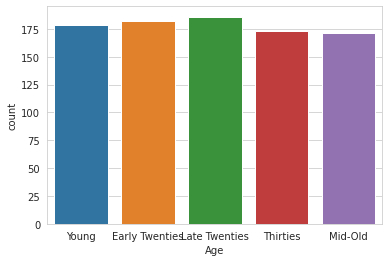

In [19]:
# visualizing binned age
seaborn.countplot(x='Age', data=train_data)

## 2. Feature engineering
Things to consider - does survival rate relate to:
- sex? survival vs sex
- having a family on board? survival vs (siblings, parents) 
- cabin class/being rich? survival vs cabin
- age? survival vs age
- do doctors/higher education help with survival? (personally don't think so)

How about this - https://scikit-learn.org/stable/modules/feature_selection.html

### Gender vs Survival
First, we'll have a look at the distribution of the gender according to the survived vs or not. We can use Seaborn's catplot feature to compare.

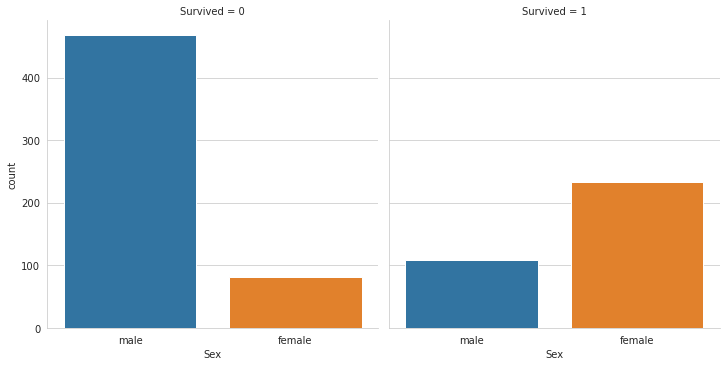

In [20]:
seaborn.catplot(x="Sex", col='Survived', data=train_data, kind='count')
### with visualization, explain by combining real-life scenario and the dataset; how it affects main psychology

We can see that many females survived, while the opposite is true for the male. Therefore, there is a strong association between sex and survival.

### Age vs Survival
Is age related to survival? Let's visualize and see.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


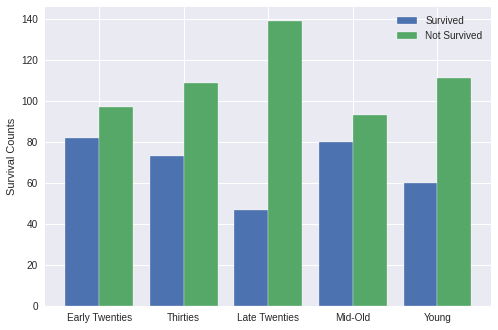

In [21]:
survived = train_data[train_data['Survived'] == 1]
died = train_data[train_data['Survived'] == 0]

# group by age
survived_age = survived.groupby(['Age'])['Survived'].count()
died_age = died.groupby(['Age'])['Survived'].count()

# graph settings
labels = train_data['Age'].unique()
x_axis = np.arange(len(labels))
width = 0.4

plt.style.use('seaborn')

result, ax = plt.subplots()
ax.bar(x_axis - width/2, survived_age, width, label='Survived')
ax.bar(x_axis + width/2, died_age, width, label='Not Survived')

ax.set_ylabel('Survival Counts')
ax.set_xticklabels(labels)
ax.set_xticks(x_axis)
ax.legend()

plt.show()

### why are there more people died in late twenties? -> assumption with explanation (gender - male, maybe a lot of males 
### on board were in late twenties age group?)
### what about p class per age and gender?

Hmm.. the late twenties showed high number of deaths, although this age group is not necessarily defined as 'old'.

### Family vs Survival
How about having family members on board? Would that increase one's survival or not?

In [22]:
train_data['SibSp'].value_counts() # would the number of siblings matter? or should we just simplify this to yes or no?

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [23]:
# what's the sum of people with 1+ siblings?
siblings = train_data[train_data['SibSp'] > 0]
siblings['SibSp'].count()

283

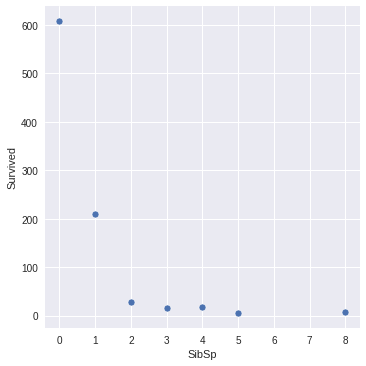

In [24]:
# this is incorrect. come back to it later.
survived_siblings = survived.groupby(['SibSp'])['Survived'].count()
#seaborn.relplot(data=survived_siblings)
seaborn.relplot(data=train_data.groupby(['SibSp'])['Survived'].count())

<AxesSubplot:xlabel='SibSp', ylabel='count'>

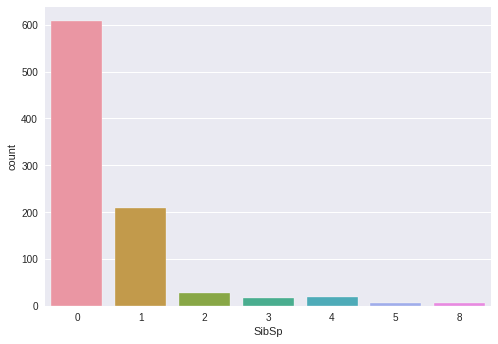

In [25]:
# how about visualization..
### log scaling to normalize the values on the graph
seaborn.countplot(x='SibSp', data=train_data)

In [26]:
# survival rate per sibling numbers
survived_siblings = survived.groupby(['SibSp'])['Survived'].count()
died_siblings = died.groupby(['SibSp'])['Survived'].count()

# checking the stats
print(train_data.groupby(['Survived','SibSp'])['Survived'].count())

Survived  SibSp
0         0        398
          1         97
          2         15
          3         12
          4         15
          5          5
          8          7
1         0        210
          1        112
          2         13
          3          4
          4          3
Name: Survived, dtype: int64


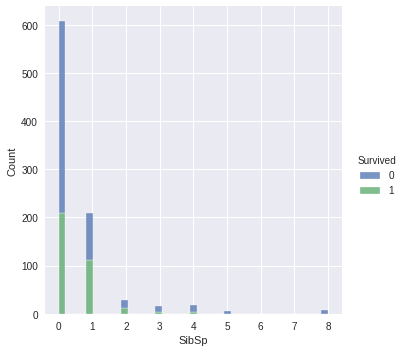

In [27]:
# visualization of survival depending on the number of siblings
### what about the number of siblings and the age vs survival?
### log scaling
seaborn.displot(train_data, x='SibSp', hue='Survived', multiple='stack') # how do I normalize?

Well, looks like passengers with <= 2 siblings have survived better (in a relationship to survival vs sibling existence). For passengers with >=4 siblings appear to be almost non-survival.

In [28]:
train_data['Parch'].value_counts()

0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Parch', ylabel='count'>

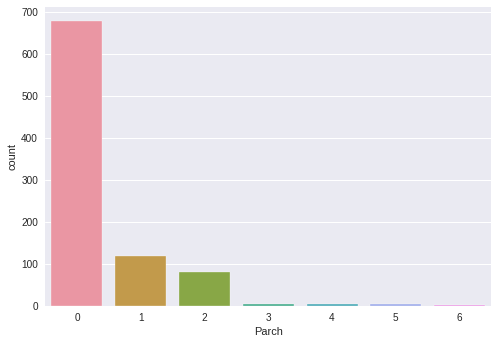

In [29]:
seaborn.countplot(train_data['Parch'])

In [30]:
# having a look at survived with parents/children
### also with the number of siblings, age
print(train_data.groupby(['Survived', 'Parch'])['Parch'].count())

Survived  Parch
0         0        445
          1         53
          2         40
          3          2
          4          4
          5          4
          6          1
1         0        233
          1         65
          2         40
          3          3
          5          1
Name: Parch, dtype: int64


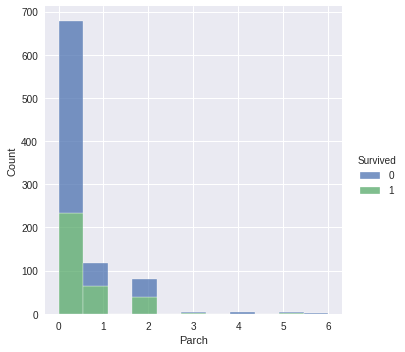

In [31]:
# i want to use scatter plot~!!
# seaborn: 
# seaborn.relplot(x='Parch', y='SibSp', data=train_data, hue='Survived')
#plt.scatter(x=train_data['Parch'].count())
seaborn.displot(train_data, x='Parch', hue='Survived', multiple='stack') #normalize?

Looks like passengers with <= 2 parents/childeren had about 50% survival/non-survival rates.
For now we'll simplify things - we'll create a new column to indicate whether a passenger had a family onboard or not.

In [32]:
# change the columns to boolean - whether there was fam or not.
train_data['SibSp'] = np.where(train_data['SibSp'] > 0, 1, 0)
train_data['Parch'] = np.where(train_data['Parch'] > 0, 1, 0)
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,Early Twenties,1,0,A/5 21171,7.2500,Unknown,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,Thirties,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,Early Twenties,0,0,STON/O2. 3101282,7.9250,Unknown,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,Thirties,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,Thirties,0,0,373450,8.0500,Unknown,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,Late Twenties,0,0,211536,13.0000,Unknown,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,Young,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,Early Twenties,1,1,W./C. 6607,23.4500,Unknown,S
889,890,1,1,"Behr, Mr. Karl Howell",male,Early Twenties,0,0,111369,30.0000,C148,C


In [33]:
test_data['SibSp'] = np.where(test_data['SibSp'] > 0, 1, 0)
test_data['Parch'] = np.where(test_data['Parch'] > 0, 1, 0)

In [34]:
# create a new column of whether family member existed or not.
train_data['Fam'] = np.where(train_data['SibSp'] | train_data['Parch'], 1, 0)
train_data = train_data.drop(['SibSp', 'Parch'], axis=1)

In [35]:
test_data['Fam'] = np.where(test_data['SibSp'] | test_data['Parch'], 1, 0)
test_data = test_data.drop(columns=['SibSp', 'Parch'])

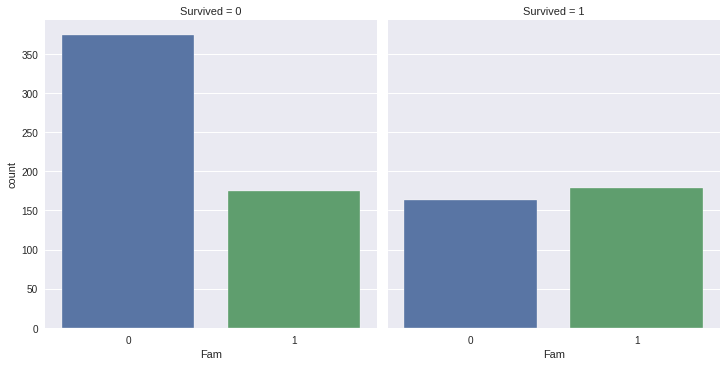

In [36]:
# visualize the survival vs fam existence
seaborn.catplot(x='Fam', col='Survived', data=train_data, kind='count') # in details - does the number of fam members matter?

In [37]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Fam
0,1,0,3,"Braund, Mr. Owen Harris",male,Early Twenties,A/5 21171,7.2500,Unknown,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,Thirties,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,Early Twenties,STON/O2. 3101282,7.9250,Unknown,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,Thirties,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,Thirties,373450,8.0500,Unknown,S,0


For the sake of simplicity, we'll drop Name feature.
Ticket, fare, cabin -- aren't these correlate to the Pclass?

In [38]:
### how is ticket, fare and pclass related?
### is there different cabin type per class or is class correlated to cabin?
### make sure to confirm these features are unnecessary
train_data = train_data.drop(columns=['Name', 'Ticket', 'Fare'])

In [39]:
test_data = test_data.drop(columns=['Name', 'Ticket', 'Fare'])

Now, let's apply label encoding. There are a few ways to do this:
* label encoding via sklearn.preprocessing.LabelEncoder
* One Hot Encoding
* find & replace

In [40]:
# trying out above options
train_data['Cabin'].value_counts()

Unknown        687
G6               4
C23 C25 C27      4
B96 B98          4
C22 C26          3
              ... 
C30              1
B37              1
A24              1
A32              1
C104             1
Name: Cabin, Length: 148, dtype: int64

Looks like the Cabin feature has way too many values. Is it worth keeping it?

In [41]:
train_data = train_data.drop(columns=['Cabin'])
train_data['Embarked'].value_counts()

S          644
C          168
Q           77
Unknown      2
Name: Embarked, dtype: int64

In [42]:
test_data = test_data.drop('Cabin', axis=1)
test_data.head()

,PassengerId,Pclass,Sex,Age,Embarked,Fam
0,892,3,male,Thirties,Q,0
1,893,3,female,Mid-Old,S,1
2,894,2,male,Mid-Old,Q,0
3,895,3,male,Late Twenties,S,0
4,896,3,female,Early Twenties,S,1


At this moment we'll drop Cabin class and perform label encoding with sklearn label encoder. We could do one-hot-encoding, but for the simplicity's sake, we'll go with the built-in function..

In [43]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in train_data.columns:
    if (train_data[col].dtypes == 'object'):
        print(col)
        train_data[col] = le.fit_transform(train_data[col])

# for Age, since the column is already category, we can use cat.codes
train_data['Age'] = train_data['Age'].cat.codes

Sex
Embarked


In [44]:
for col in test_data.columns:
    if test_data[col].dtypes == object:
        print(col)
        test_data[col] = le.fit_transform(test_data[col])

test_data['Age'] = test_data['Age'].cat.codes

Sex
Embarked


<AxesSubplot:>

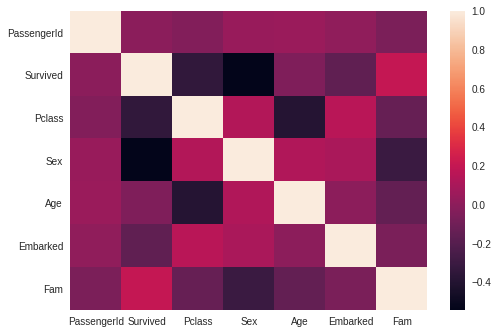

In [45]:
seaborn.heatmap(train_data.corr())

In [46]:
train_data.corr()

,PassengerId,Survived,Pclass,Sex,Age,Embarked,Fam
PassengerId,1.000000,-0.005007,-0.035144,0.042939,0.049628,0.013083,-0.057462
Survived,-0.005007,1.000000,-0.338481,-0.543351,-0.045072,-0.163517,0.203367
Pclass,-0.035144,-0.338481,1.000000,0.131900,-0.391773,0.157112,-0.135207
Sex,0.042939,-0.543351,0.131900,1.000000,0.129239,0.104057,-0.303646
Age,0.049628,-0.045072,-0.391773,0.129239,1.000000,0.001479,-0.147220
Embarked,0.013083,-0.163517,0.157112,0.104057,0.001479,1.000000,-0.065610
Fam,-0.057462,0.203367,-0.135207,-0.303646,-0.147220,-0.065610,1.000000


## 3. Modeling and Evaluation

Let's try out a few classifiers from sklearn.
- Ensemble classifier: combined predictions of several models.
- Decision tree: prediction from decisive rules learned from data structure
- Support Vector Machine: https://scikit-learn.org/stable/modules/svm.html

In [47]:
train_data.head()

,PassengerId,Survived,Pclass,Sex,Age,Embarked,Fam
0,1,0,3,1,1,2,1
1,2,1,1,0,3,0,1
2,3,1,3,0,1,2,0
3,4,1,1,0,3,2,1
4,5,0,3,1,3,2,0


In [48]:
from sklearn.model_selection import train_test_split

y = train_data['Survived']
X = train_data.drop('Survived', axis=1)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3)

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import svm

rf_classifier = RandomForestClassifier()
dt_classifier = tree.DecisionTreeClassifier()
svm = svm.SVC()

In [50]:
# rf_classifier.fit(X, y)
rf_classifier.fit(train_X, train_y)

RandomForestClassifier()

In [51]:
# dt_classifier.fit(X, y)
dt_classifier.fit(train_X, train_y)

DecisionTreeClassifier()

In [52]:
# svm.fit(X, y)
svm.fit(train_X, train_y)

SVC()

In [53]:
# y_pred = rf_classifier.predict(test_data)
y_pred = rf_classifier.predict(test_X)

In [54]:
# y_pred2 = dt_classifier.predict(test_data)
y_pred2 = dt_classifier.predict(test_X)

In [55]:
# y_pred3 = svm.predict(test_data)
y_pred3 = svm.predict(test_X)

In [56]:
### which models are better suited and why? (pros and cons)
### explanation of why classifier worked better than the other(s)
from sklearn.metrics import accuracy_score, confusion_matrix

rf_accuracy = accuracy_score(test_y, y_pred)
dt_accuracy = accuracy_score(test_y, y_pred2)
svm_accuracy = accuracy_score(test_y, y_pred3)

print("Random Forest classifier accuracy: ", rf_accuracy)
print("Decision tree classifier accuracy: ", dt_accuracy)
print("SVM classifier accuracy: ", svm_accuracy) ### why is SVM has worse accuracy than the other classifiers?

Random Forest classifier accuracy:  0.7313432835820896
Decision tree classifier accuracy:  0.7014925373134329
SVM classifier accuracy:  0.5783582089552238


Random Forest classifier showed the highest accuracy. Why?

<AxesSubplot:>

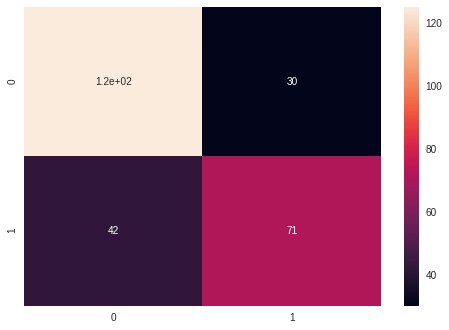

In [58]:
# rf classifier
seaborn.heatmap(confusion_matrix(test_y, y_pred), annot=True)

<AxesSubplot:>

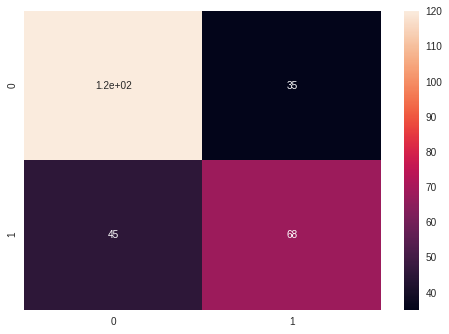

In [60]:
# decision tree classifier
seaborn.heatmap(confusion_matrix(test_y, y_pred2), annot=True)

<AxesSubplot:>

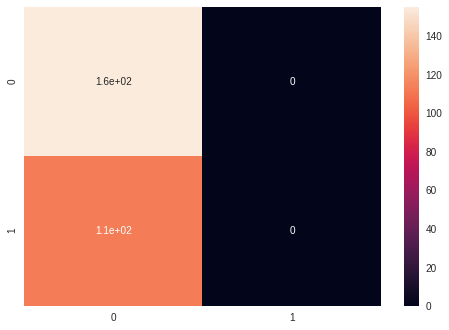

In [61]:
# svm
seaborn.heatmap(confusion_matrix(test_y, y_pred3), annot=True)

<AxesSubplot:>

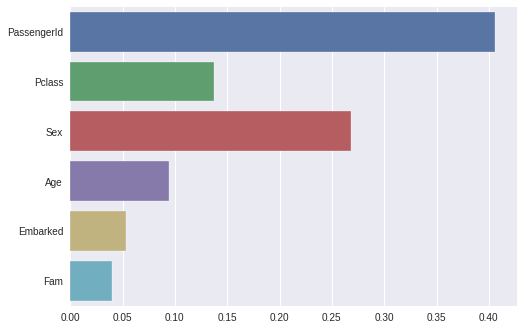

In [70]:
### captions on the visualizations
# feature importance from random forest

labels = X.columns
seaborn.barplot(y=labels, x=rf_classifier.feature_importances_)

<AxesSubplot:>

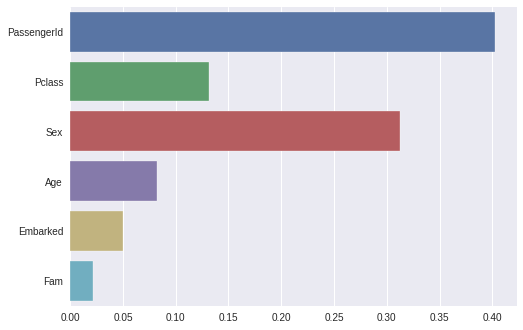

In [71]:
# feature importance from decison tree
seaborn.barplot(y=labels, x=dt_classifier.feature_importances_)

In [73]:
# combined graph
data = {'labels': labels, 'rf': rf_classifier.feature_importances_, 'dt': dt_classifier.feature_importances_}
feature_importance = pd.DataFrame(data=data)
seaborn.barplot(y=feature_importance['labels'], x=feature_importance['rf', 'dt'])

KeyError: ('rf', 'dt')